In [1]:
# Import necessary libraries for data handling, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import scikit-learn components for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset from the CSV file into a pandas DataFrame
df = pd.read_csv('adult 3.csv')

# Display the first 5 rows to get a feel for the data
print("--- First 5 Rows ---")
df.head()



--- First 5 Rows ---


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# Replace the placeholder '?' with NumPy's Not a Number (NaN) for easier handling
df.replace('?', np.nan, inplace=True)

# Check for and count any duplicate rows in the dataset
print(f"Number of duplicate rows found: {df.duplicated().sum()}")

# Remove the duplicate rows to ensure data quality
df.drop_duplicates(inplace=True)

# Print the number of rows after removing duplicates to confirm the operation
print(f"Number of rows after removing duplicates: {len(df)}")


Number of duplicate rows found: 52
Number of rows after removing duplicates: 48790


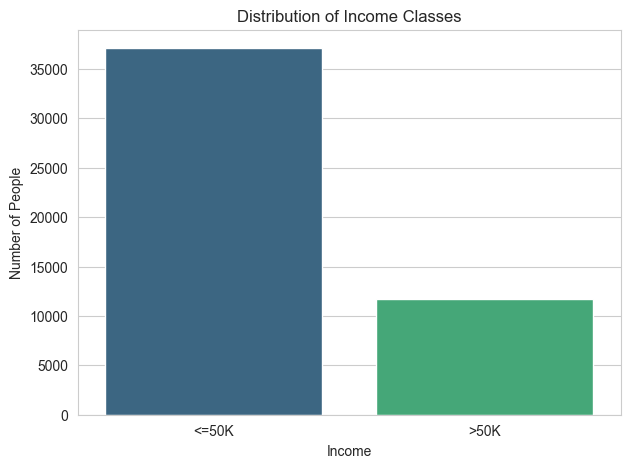

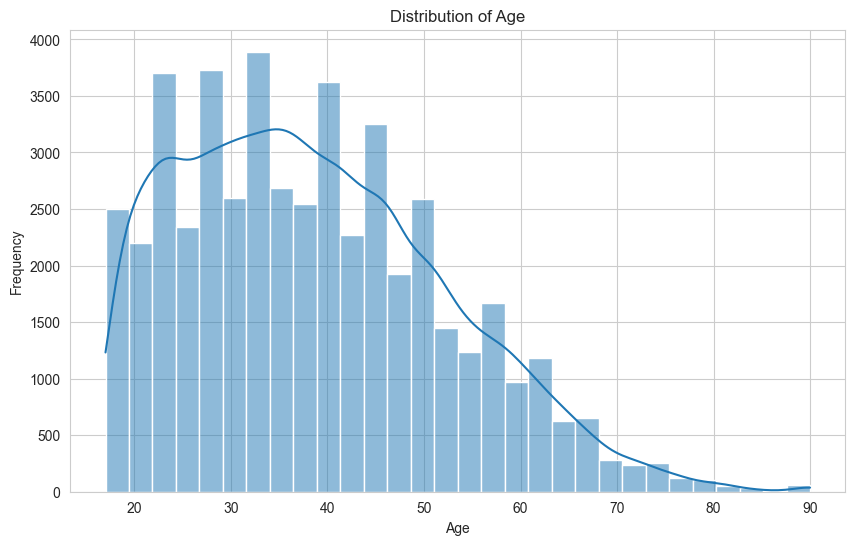

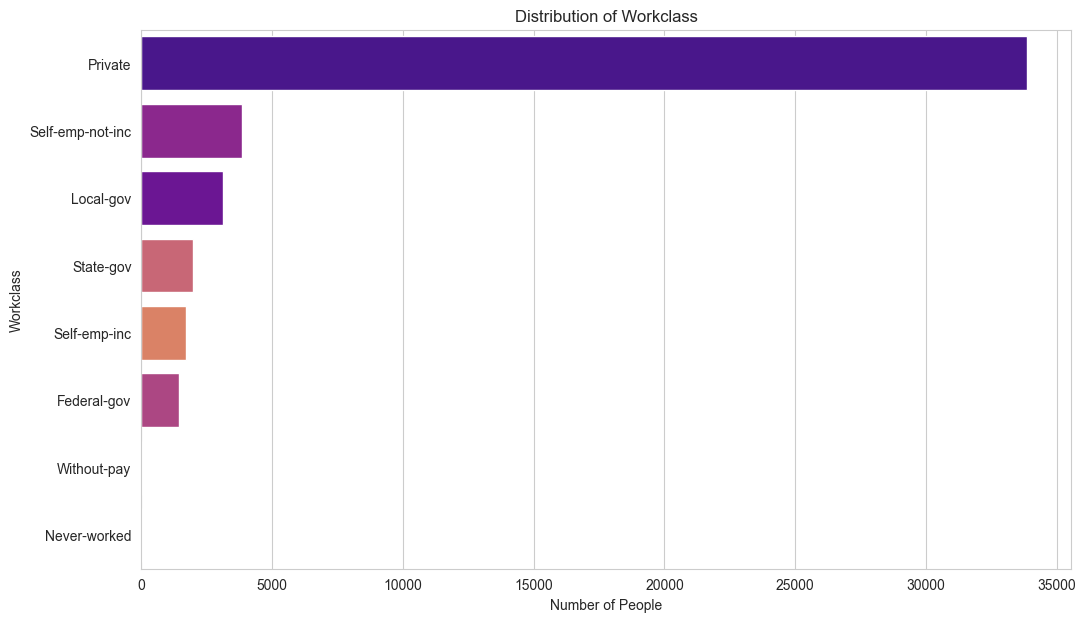

In [4]:
# Set the visual style for all upcoming plots
sns.set_style("whitegrid")

# --- Plot 1: Distribution of the Target Variable (Income) ---
plt.figure(figsize=(7, 5)) # Create a figure with a specific size
sns.countplot(data=df, x='income', hue='income', palette='viridis', legend=False) # Create a count plot for the 'income' column
plt.title('Distribution of Income Classes') # Set the title of the plot
plt.xlabel('Income') # Set the label for the x-axis
plt.ylabel('Number of People') # Set the label for the y-axis
plt.show() # Display the plot

# %%
# --- Plot 2: Distribution of Age ---
plt.figure(figsize=(10, 6)) # Create a new figure
sns.histplot(df['age'], bins=30, kde=True) # Create a histogram for the 'age' column with a density curve
plt.title('Distribution of Age') # Set the plot title
plt.xlabel('Age') # Set the x-axis label
plt.ylabel('Frequency') # Set the y-axis label
plt.show() # Display the plot

# %%
# --- Plot 3: Distribution of Workclass ---
plt.figure(figsize=(12, 7)) # Create a new figure
sns.countplot(data=df, y='workclass', order=df['workclass'].value_counts().index, hue='workclass', palette='plasma', legend=False) # Create a horizontal count plot for 'workclass'
plt.title('Distribution of Workclass') # Set the plot title
plt.xlabel('Number of People') # Set the x-axis label
plt.ylabel('Workclass') # Set the y-axis label
plt.show() # Display the plot


In [5]:
# Drop columns that are redundant ('education') or not useful for prediction ('fnlwgt')
df_engineered = df.drop(columns=['education', 'fnlwgt'])
print("Columns have been dropped. Remaining columns:")
print(df_engineered.columns)

# Separate the data into features (X) and the target variable (y)
X = df_engineered.drop('income', axis=1) # All columns except 'income'
y = df_engineered['income'] # Only the 'income' column

# --- Preprocessing Pipeline Setup ---
# Identify which columns are categorical (text) and which are numerical
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a pipeline for numerical data: fill missing values with the median, then scale the data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Step 1: Impute missing values
    ('scaler', StandardScaler()) # Step 2: Scale features to have zero mean and unit variance
])

# Create a pipeline for categorical data: fill missing values with the most frequent value, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Step 1: Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Step 2: Convert categories into binary columns
])

# Create a master preprocessor to apply the correct transformation to each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), # Apply numerical transformer to numerical columns
        ('cat', categorical_transformer, categorical_features) # Apply categorical transformer to categorical columns
    ])



Columns have been dropped. Remaining columns:
Index(['age', 'workclass', 'educational-num', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'income'],
      dtype='object')


In [6]:
# Split the data into training (80%) and testing (20%) sets
# 'stratify=y' ensures the proportion of income classes is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split complete. Training set has {X_train.shape[0]} samples.")

# --- Model Definitions ---
# Define the three models we want to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# --- Training and Evaluation Loop ---
# Create a dictionary to store the accuracy results of each model
results = {}

# Loop through each model
for name, model in models.items():
    # Create the full pipeline, from preprocessing to the final classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the unseen test data
    y_pred = pipeline.predict(X_test)

    # Calculate the accuracy of the predictions
    accuracy = accuracy_score(y_test, y_pred)

    # Store the accuracy in our results dictionary
    results[name] = accuracy
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}\n")



Data split complete. Training set has 39032 samples.
--- Logistic Regression ---
Accuracy: 0.8488

--- Decision Tree ---
Accuracy: 0.8163

--- Random Forest ---
Accuracy: 0.8447



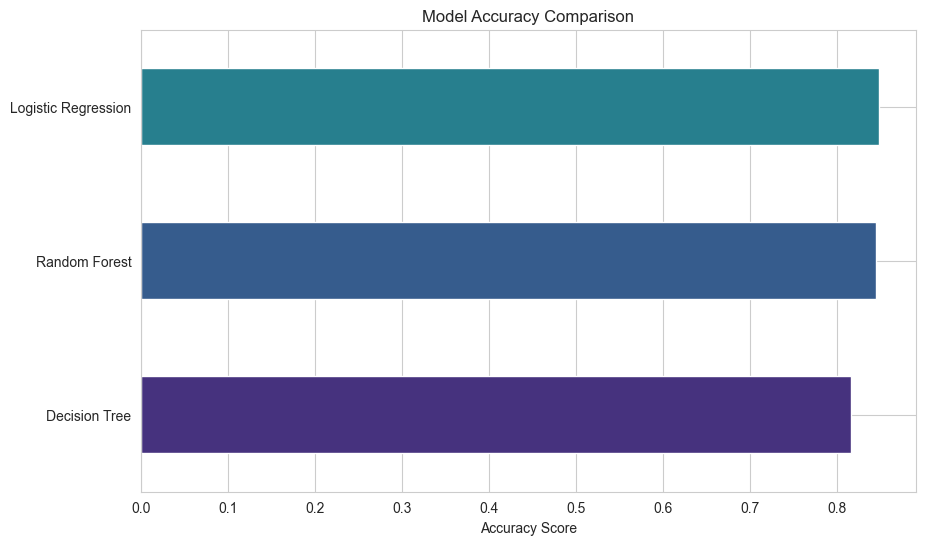

Best performing model: Logistic Regression with an accuracy of 0.8488

Best model pipeline has been saved to 'best_model_refined.pkl'


In [7]:
# Convert the results dictionary to a pandas Series for easy plotting
accuracies = pd.Series(results)

# Create a bar chart to compare the accuracies
plt.figure(figsize=(10, 6)) # Create a new figure
accuracies.sort_values().plot(kind='barh', color=sns.color_palette('viridis')) # Create a horizontal bar plot
plt.title('Model Accuracy Comparison') # Set the plot title
plt.xlabel('Accuracy Score') # Set the x-axis label
plt.show() # Display the plot

# --- Save the Best Model ---
# Find the name of the model with the highest accuracy score
best_model_name = accuracies.idxmax()
print(f"Best performing model: {best_model_name} with an accuracy of {accuracies.max():.4f}")

# Create the final pipeline using the best model definition
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', models[best_model_name])])

# Fit the final pipeline on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Save the entire pipeline object to a file named 'best_model_refined.pkl'
joblib.dump(best_pipeline, 'best_model_refined.pkl')
print("\nBest model pipeline has been saved to 'best_model_refined.pkl'")



In [10]:
%%writefile app.py

# Import necessary libraries
import streamlit as st
import pandas as pd
import joblib

# --- Load the Trained Model ---
# Load the pipeline object that contains both the preprocessor and the best model
try:
    pipeline = joblib.load('best_model_refined.pkl')
except FileNotFoundError:
    st.error("Error: 'best_model_refined.pkl' not found. Please make sure the model file is in the same directory as this script.")
    st.stop() # Stop the app if the model file is not found

# --- Set Up the User Interface ---
st.set_page_config(page_title="Salary Predictor", page_icon="💼", layout="wide")

# Add a title and a description to the app
st.title("💼 Employee Salary Predictor")
st.write(
    "This application uses a machine learning model to predict whether an employee's salary "
    "is greater than $50,000 per year based on their demographic and professional details."
)
st.markdown("---")

# Create columns for a clean layout
col1, col2 = st.columns(2)

# Create input fields in the first column
with col1:
    st.header("Personal Details")
    age = st.number_input("Age", min_value=17, max_value=90, value=30)
    marital_status = st.selectbox("Marital Status", ['Married-civ-spouse', 'Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'])
    relationship = st.selectbox("Relationship", ['Husband', 'Not-in-family', 'Own-child', 'Unmarried', 'Wife', 'Other-relative'])
    race = st.selectbox("Race", ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'])
    gender = st.selectbox("Gender", ['Male', 'Female'])

# Create input fields in the second column
with col2:
    st.header("Professional Details")
    workclass = st.selectbox("Workclass", ['Private', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Self-emp-inc', 'Federal-gov', 'Without-pay'])
    educational_num = st.slider("Education Level (Numeric)", 1, 16, 10)
    occupation = st.selectbox("Occupation", ['Prof-specialty', 'Craft-repair', 'Exec-managerial', 'Adm-clerical', 'Sales', 'Other-service', 'Machine-op-inspct', 'Transport-moving', 'Handlers-cleaners', 'Farming-fishing', 'Tech-support', 'Protective-serv', 'Priv-house-serv', 'Armed-Forces'])
    hours_per_week = st.number_input("Hours per Week", min_value=1, max_value=99, value=40)
    native_country = st.selectbox("Native Country", ['United-States', 'Mexico', 'Philippines', 'Germany', 'Puerto-Rico', 'Canada', 'El-Salvador', 'India', 'Cuba', 'England', 'China', 'South', 'Jamaica', 'Italy', 'Dominican-Republic', 'Japan', 'Guatemala', 'Vietnam', 'Columbia', 'Poland', 'Haiti', 'Portugal', 'Iran', 'Taiwan', 'Greece', 'Nicaragua', 'Peru', 'Ecuador', 'France', 'Ireland', 'Hong', 'Thailand', 'Cambodia', 'Trinadad&Tobago', 'Laos', 'Yugoslavia', 'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Honduras', 'Hungary'])

# Create input fields for financial details that span the full width
st.header("Financial Details")
capital_gain = st.number_input("Capital Gain", min_value=0, value=0)
capital_loss = st.number_input("Capital Loss", min_value=0, value=0)

st.markdown("---")

# --- Prediction Logic ---
# Create a button that will trigger the prediction
if st.button("Predict Salary", type="primary"):
    # Create a dictionary from the user's input
    # The keys must match the column names from the training data
    input_data = {
        'age': age,
        'workclass': workclass,
        'educational-num': educational_num,
        'marital-status': marital_status,
        'occupation': occupation,
        'relationship': relationship,
        'race': race,
        'gender': gender,
        'capital-gain': capital_gain,
        'capital-loss': capital_loss,
        'hours-per-week': hours_per_week,
        'native-country': native_country
    }

    # Convert the dictionary into a pandas DataFrame
    input_df = pd.DataFrame([input_data])

    # Use the loaded pipeline to make a prediction
    prediction = pipeline.predict(input_df)

    # Get the probability of the prediction
    prediction_proba = pipeline.predict_proba(input_df)

    # Display the result
    st.subheader("Prediction Result")
    if prediction[0] == '>50K':
        st.success("The predicted salary is **greater than $50,000**.")
        st.write(f"Confidence: {prediction_proba[0][1]:.2%}")
    else:
        st.error("The predicted salary is **less than or equal to $50,000**.")
        st.write(f"Confidence: {prediction_proba[0][0]:.2%}")


Overwriting app.py


In [11]:
!ngrok authtoken 30BopWV9tHgAEywj5nA4yGm6Fgo_3pfabsVbFNZrXCssyiiPz

Authtoken saved to configuration file: C:\Users\Aakash\AppData\Local/ngrok/ngrok.yml


In [12]:
import os
import threading
import time
from pyngrok import ngrok

# Define a function to run the Streamlit app
def run_streamlit():
    # The command to run the streamlit app on a specific port
    os.system('streamlit run app.py --server.port 8501')

# --- Start the Streamlit App in a Background Thread ---
# This ensures the notebook cell doesn't get stuck waiting for the app to close
thread = threading.Thread(target=run_streamlit)
thread.start()

# --- Set up the Ngrok Tunnel ---
# Wait a few seconds to make sure the Streamlit server has fully started
print("Starting Streamlit server... please wait.")
time.sleep(5)

# Authenticate ngrok (you only need to do this once, you can comment it out after the first run)
# Replace 'YOUR_NGROK_AUTHTOKEN' with your actual token from the ngrok dashboard
# ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")


# Create a public URL for the Streamlit app running on port 8501
public_url = ngrok.connect(8501)

# Print the public URL
print("\n" + "="*40)
print("Your Streamlit app is live at:")
print(public_url)
print("="*40)



Starting Streamlit server... please wait.

Your Streamlit app is live at:
NgrokTunnel: "https://a1e9da54f7b3.ngrok-free.app" -> "http://localhost:8501"
